In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sat Feb 26 2022
Last revised on Thu Apr 20 2023

A Jupyer Notebook for < Multimodal integration of neuroimaging and genetic data for the diagnosis of mood disorders based on computer vision models >
ViT-XGBoost (imaging genomics)

@author: 

"""

In [ ]:
from tqdm import tqdm
from glob import glob
import os
import gc
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
import nibabel as nib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from skimage.transform import resize
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torchvision.models as models
import torchsummary
from collections import OrderedDict
import cv2
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import confusion_matrix, roc_auc_score, auc
import seaborn as sns

import timm
# from timm.data import resolve_data_config
# from timm.data.transforms_factory import create_transform

%matplotlib inline

In [ ]:
import torch
import random
import torch.backends.cudnn as cudnn

torch.manual_seed(256)
torch.cuda.manual_seed(256)
torch.cuda.manual_seed_all(256)
np.random.seed(0)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scaler = StandardScaler()

print(torch.cuda.is_available())
print(torch.cuda.current_device())

In [ ]:
# Patient ID list
# MUST fix the order of patient ID

idlist = pd.read_csv("/path/to/patient/ID/csv/").drop(['Unnamed: 0'], axis = 1)

# SNP data
snp = pd.read_csv("/path/to/snp/csv/").drop(['Unnamed: 0'],axis=1)

# trait data - Control, MDD, BD
original = pd.read_csv("/path/to/trait/csv/")

In [ ]:
# target - 0 for Control, 1 for MDD, 2 for BD
target = []
for i in range(321):
  if original['trait'][i] == 'Control':
    target.append(0)
  elif original['trait'][i] == 'MDD':
    target.append(1)
  else:
    target.append(2)

target = np.array(target)

In [ ]:
# train

traindata = []
traindata_snp = []
trainidx = []
for i in range(len(idx_train)):
  traindata.append(data[idx_train[i]])
  traindata_snp.append(snp.loc[idx_train[i], :].values)
  trainidx.append(target[idx_train[i]])

trainidx = np.array(trainidx)
traindata1 = np.array(traindata)
traindata2 = np.array(traindata_snp)

assert len(traindata1) == len(traindata2)

# test

testdata = []
testdata_snp = []
testidx = []

for i in range(len(idx_test)):
  testdata.append(data[idx_test[i]])
  testdata_snp.append(snp.loc[idx_test[i], :].values)
  testidx.append(target[idx_test[i]])

testidx = np.array(testidx)

testfinal = []
testfinal2 = []

for i in range(len(testdata)):
    testfinal.append((testdata[i], testidx[i]))
    testfinal2.append((testdata_snp[i], testidx[i]))

testloader = DataLoader(testfinal, batch_size = batchsize, shuffle = False)
testloader2 = DataLoader(testfinal2, batch_size = batchsize, shuffle = False)

In [ ]:
# split train and test dataset

idx_list = []
for i in range(len(data)):
  idx_list.append(i)

idx_train, idx_test = train_test_split(idx_list, test_size = 0.1, shuffle = True, random_state = 256)

In [ ]:
# Vision Transformer
# ViT-L/32 (a large variant of Vision Transformer with a patch size of 32*32) with input image size = 384*384


model = timm.create_model('vit_large_patch32_384', pretrained=True).cuda()

for parameter in model.parameters():
    parameter.requires_grad = False

num_features = model.head.in_features
model.head = nn.Linear(num_features, 3) # Control, MDD, BD -> 3
model = model.cuda()

In [ ]:
# Hyper-parameters

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch : 0.95 ** epoch)
epochs = 100
batchsize = 32

In [ ]:
# train

def train(model, train_loader, optimizer, log_interval):
  model.train()
  prob = []
  labellist = []
  for batch_idx, (image, label) in enumerate(train_loader):
    image = image.to(device, dtype=torch.float)
    label = label.to(device)
    labellist.append(label)
    optimizer.zero_grad()
    output = model(image)
    prob.append(output)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()
    
    if batch_idx % log_interval == 0:
      print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))
      
  scheduler.step()
  return prob, labellist

In [ ]:
# evaluate (test)

def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    temp1 = []
    temp2 = []
    prob = []

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(device, dtype = torch.float)

            label = label.to(device)
            temp1.append(label)
            output = model(image)
            prob.append(output)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
            temp2.append(prediction)
    
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy, temp1, temp2, prob

In [ ]:
# snp_loader

def snp_loader(model, test_loader):
    model.eval()
    
    snpdata = []
    snplabel = []

    with torch.no_grad():
        for image, label in test_loader:
            snpdata.append(image)
            snplabel.append(label)
    
    return snpdata, snplabel

In [ ]:
# End-to-End Architecture with two steps: (1) ViT (T1 MRI), (2) XGBoost (SNP)
# First, ViT results are printed out -> Then the final XGBoost results come out

# Training, Validation, Test dataset are completely separated -> NO bias!
# For LightGBM: only need to change codes for XGBoost -> LightGBM

In [ ]:
# K-Fold Cross-Validation
# use 10-fold

kfold = 10
skf = StratifiedKFold(n_splits = kfold, shuffle = True, random_state = 256)

# parameters for XGBoost

params = {'max_depth':7, 'eta':0.1, 'objective':'multi:softprob', 'eval_metric':'mlogloss', 'early_stopping':100, 'num_class':3, 'n_estimators':1000}
num_rounds = 1000

In [ ]:
image_testlabel = [] # test dataset class (Ground Truth), same as testidx
image_testpred = [] # ViT Precition w/ test dataset
image_testloss = [] # ViT loss w/ test dataset
image_testacc = [] # ViT Accuracy w/ test dataset
image_testprob = [] # ViT Output (Probability-like) w/ test dataset

cv_acc = [] # Fusion Model Accuracy w/ test dataset
finalprob = [] # Fusion Model Output (Probability-like) w/ test dataset
finalpred = [] # Fusion Model Precition w/ test dataset

for i, (train_index, val_index) in enumerate(skf.split(traindata1, trainidx)):
    
    print('[Fold %d/%d]' % (i + 1, kfold))
    
    
    X_train, X_valid = traindata1[train_index], traindata1[val_index]
    X_train2, X_valid2 = traindata2[train_index], traindata2[val_index]
    y_train, y_valid = trainidx[train_index], trainidx[val_index]

    
    # train
    
    trainfinal = []
    trainfinal2 = []

    for j in range(X_train.shape[0]):
      trainfinal.append((X_train[j], y_train[j]))
      trainfinal2.append((X_train2[j], y_train[j]))

    
    # validation

    valfinal = []
    valfinal2 = []

    for j in range(X_valid.shape[0]):
      valfinal.append((X_valid[j], y_valid[j]))
      valfinal2.append((X_valid2[j], y_valid[j]))

    trainloader = DataLoader(trainfinal, batch_size = batchsize, shuffle = False)
    trainloader2 = DataLoader(trainfinal2, batch_size = batchsize, shuffle = False)
    validloader = DataLoader(valfinal, batch_size = batchsize, shuffle = False)
    validloader2 = DataLoader(valfinal2, batch_size = batchsize, shuffle = False)
    
    
    print('[Fold %d/%d Prediciton:]' % (i + 1, kfold))
    

    # 1. ViT
    # train

    epochval = []
    valloss = []
    valacc = []

    for epoch in range(1, epochs + 1):
        trainprob, trainlabel = train(model, trainloader, optimizer, log_interval = 5)
        valid_loss, valid_accuracy, validlabel, _, validprob = evaluate(model, validloader)
        epochval.append(epoch)
        valloss.append(valid_loss)
        valacc.append(valid_accuracy)
        print("\n[EPOCH: {}], \tValidation Loss: {:.6f}, \tValidation Accuracy: {:.6f} % \n".format(
            epoch, valid_loss, valid_accuracy))
    

    # test

    test_loss, test_accuracy, label, pred, prob = evaluate(model, testloader)
    image_testlabel.append(label)
    image_testpred.append(pred)
    image_testloss.append(test_loss)
    image_testacc.append(test_accuracy)
    image_testprob.append(prob)

    print("\nTest Loss: {:.4f}, \tTest Accuracy: {:.4f} % \n".format(test_loss, test_accuracy))
    
    ## Merging features extracted from ViT above (3) & SNP data (281) 
    ## Should deal with train / validation / test dataset, separately


    ## train

    # 1) ViT
    vittrainprob = torch.cat((trainprob[0], trainprob[1], trainprob[2], trainprob[3], trainprob[4], trainprob[5], trainprob[6], trainprob[7], trainprob[8]), 0).detach().cpu().numpy()
    vittrainlabel = torch.cat((trainlabel[0], trainlabel[1], trainlabel[2], trainlabel[3], trainlabel[4], trainlabel[5], trainlabel[6], trainlabel[7], trainlabel[8]), 0).detach().cpu().numpy()
    
    # 2) SNP
    trainsnpdata, trainsnplabel = snp_loader(model, trainloader2)

    # Note that the # of array may vary by the total sample size
    snpdatatrain = torch.cat((trainsnpdata[0], trainsnpdata[1], trainsnpdata[2], trainsnpdata[3], trainsnpdata[4], trainsnpdata[5], trainsnpdata[6], trainsnpdata[7], trainsnpdata[8]),0).detach().cpu().numpy()
    trainlabelgiven = torch.cat((trainsnplabel[0], trainsnplabel[1], trainsnplabel[2], trainsnplabel[3], trainsnplabel[4], trainsnplabel[5], trainsnplabel[6], trainsnplabel[7], trainsnplabel[8]),0).detach().cpu().numpy()
    
    # check whether each image and snp data are well aligned
    assert (vittrainlabel == trainlabelgiven).all()
    
    fusion_data_train = np.concatenate((vittrainprob, snpdatatrain), axis=1)
    fusion_data_train = pd.DataFrame(fusion_data_train)
    fusion_data_train['target'] = trainlabelgiven.reshape(len(trainlabelgiven), 1)



    ## validation

    # 1) ViT
    vitvalidprob = validprob[0].detach().cpu().numpy()
    vitvalidlabel = validlabel[0].detach().cpu().numpy()
    
    # 2) SNP
    validsnpdata, validsnplabel = snp_loader(model, validloader2)
    
    # Note that the # of array may vary by the total sample size
    snpdatavalid = validsnpdata[0].detach().cpu().numpy()
    validlabelgiven = validsnplabel[0].detach().cpu().numpy()
    
    # check whether each image and snp data are well aligned
    assert (vitvalidlabel == validlabelgiven).all()
    
    fusion_data_valid = np.concatenate((vitvalidprob, snpdatavalid), axis=1)
    fusion_data_valid = pd.DataFrame(fusion_data_valid)
    fusion_data_valid['target'] = validlabelgiven.reshape(len(validlabelgiven), 1)



    ## test

    # 1) ViT
    vittestprob = np.concatenate((prob[0].detach().cpu().numpy(), prob[1].detach().cpu().numpy()))
    vittestlabel = np.concatenate((label[0].detach().cpu().numpy(), label[1].detach().cpu().numpy()))
    
    # 2) SNP
    testsnpdata, testsnplabel = snp_loader(model, testloader2)
    
    # Note that the # of array may vary by the total sample size
    snpdatatest = np.concatenate((testsnpdata[0].detach().cpu().numpy(), testsnpdata[1].detach().cpu().numpy()))
    labeltestgiven = np.concatenate((testsnplabel[0].detach().cpu().numpy(), testsnplabel[1].detach().cpu().numpy()))
    
    # check whether each image and snp data are well aligned
    assert (vittestlabel == labeltestgiven).all()

    
    
    # 2. XGBoost
    
    fusion_data_test = np.concatenate((vittestprob, snpdatatest), axis=1)
    fusion_data_test = pd.DataFrame(fusion_data_test)
    fusion_data_test['target'] = labeltestgiven.reshape(33, 1)


    X_train_new, X_valid_new = fusion_data_train.drop(['target'],axis=1), fusion_data_valid.drop(['target'],axis=1)
    y_train_new, y_valid_new = fusion_data_train['target'].values, fusion_data_valid['target'].values


    d_train = xgb.DMatrix(X_train_new, y_train_new)
    d_valid = xgb.DMatrix(X_valid_new, y_valid_new)
    d_test = xgb.DMatrix(fusion_data_test.drop(['target'],axis=1), fusion_data_test['target'].values)

    wlist = [(d_train, 'train'), (d_valid, 'valid')]
    xgb_model = xgb.train(params = params, dtrain = d_train, num_boost_round = num_rounds, early_stopping_rounds = 200, evals = wlist)



    temp = xgb_model.predict(d_test)
    finalprob.append(temp) # Fusion Model Output (Probability-like) w/ test dataset
    
    temp2 = []
    
    for j in range(len(testidx)):
      temp2.append(np.argsort(temp[j])[::-1][0])
      
    acc = np.round(accuracy_score(testidx, temp2), 4)
    
    cv_acc.append(acc) # Fusion Model Accuracy w/ test dataset
    finalpred.append(temp2) # Fusion Model Precition w/ test dataset

In [ ]:
# reference: https://github.com/vinyluis/Articles/tree/main/ROC%20Curve%20and%20ROC%20AUC

def calculate_tpr_fpr(y_real, y_pred):
    '''
    Calculates the True Positive Rate (tpr) and the True Negative Rate (fpr) based on real and predicted observations
    
    Args:
        y_real: The list or series with the real classes
        y_pred: The list or series with the predicted classes
        
    Returns:
        tpr: The True Positive Rate of the classifier
        fpr: The False Positive Rate of the classifier
    '''
    
    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    
    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate
    
    return tpr, fpr

In [ ]:
def get_all_roc_coordinates(y_real, y_proba):
    '''
    Calculates all the ROC Curve coordinates (tpr and fpr) by considering each point as a treshold for the predicion of the class.
    
    Args:
        y_real: The list or series with the real classes.
        y_proba: The array with the probabilities for each class, obtained by using the `.predict_proba()` method.
        
    Returns:
        tpr_list: The list of TPRs representing each threshold.
        fpr_list: The list of FPRs representing each threshold.
    '''
    tpr_list = [0, 1]
    fpr_list = [0, 1]
    for i in range(len(y_proba)):
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list

In [ ]:
def plot_roc_curve_blue(tpr, fpr, scatter = True, ax = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
    
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax, ci=None, color='skyblue', alpha = 0.05)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'black', ax = ax, alpha = 0.05, linestyle='--')
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

In [ ]:
def plot_roc_curve_red(tpr, fpr, scatter = True, ax = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
    
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax, ci=None, color='red', alpha = 0.05)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'black', ax = ax, alpha = 0.05, linestyle='--')
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

In [ ]:
def plot_roc_curve_green(tpr, fpr, scatter = True, ax = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
    
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax, ci=None, color='green', alpha = 0.05)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'black', ax = ax, alpha = 0.05, linestyle='--')
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

In [ ]:
classes = [0, 1, 2]
classes_names = ['Control', 'MDD', 'Bipolar']

In [ ]:
prob2 = finalprob

# ROC Cuve w/ blue lines

plt.figure(figsize = (12, 8))
roc_auc_ovr = {}
auc = []
    
for i in range(len(classes)):
    
    temptpr = []
    tempfpr = []
    
    for j in range(10):

        c = classes[i]

        df_aux = pd.DataFrame(testdata).copy()
        df_aux['class'] = [1 if y == c else 0 for y in testidx]
        df_aux['prob'] = np.array(prob2)[j][:, i]
        df_aux = df_aux.reset_index(drop = True)

        ax_bottom = plt.subplot(2, 3, i+4)
        tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])


        temptpr.append(tpr)
        tempfpr.append(fpr)
        
        plot_roc_curve_blue(tpr, fpr, scatter = False, ax = ax_bottom)
        
        
        ax_bottom.set_title(f"ROC Curve OvR: {classes_names[c]} vs. Rest")

        auc.append(roc_auc_score(df_aux['class'], df_aux['prob']))
    
    temptpr = np.array(temptpr)
    tempfpr = np.array(tempfpr)
    
    num = 9 + i * 10
    prev = 9 + (i-1)*10
    plt.plot(np.sort(np.array(pd.DataFrame(tempfpr).mean())), np.sort(np.array(pd.DataFrame(temptpr).mean())), 'b')

    plt.tight_layout()

In [ ]:
# ROC Cuve w/ red lines

plt.figure(figsize = (12, 8))
roc_auc_ovr = {}
auc = []
    
for i in range(len(classes)):
    
    temptpr = []
    tempfpr = []
    
    for j in range(10):

        c = classes[i]

        df_aux = pd.DataFrame(testdata).copy()
        df_aux['class'] = [1 if y == c else 0 for y in testidx]
        df_aux['prob'] = np.array(prob2)[j][:, i]
        df_aux = df_aux.reset_index(drop = True)

        ax_bottom = plt.subplot(2, 3, i+4)
        tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])


        temptpr.append(tpr)
        tempfpr.append(fpr)
        
        plot_roc_curve_red(tpr, fpr, scatter = False, ax = ax_bottom)
        
        
        ax_bottom.set_title(f"ROC Curve OvR: {classes_names[c]} vs. Rest")

        auc.append(roc_auc_score(df_aux['class'], df_aux['prob']))
    
    temptpr = np.array(temptpr)
    tempfpr = np.array(tempfpr)
    
    num = 9 + i * 10
    prev = 9 + (i-1)*10
    plt.plot(np.sort(np.array(pd.DataFrame(tempfpr).mean())), np.sort(np.array(pd.DataFrame(temptpr).mean())), 'r')

    plt.tight_layout()

In [ ]:
# ROC Cuve w/ green lines

plt.figure(figsize = (12, 8))
roc_auc_ovr = {}
auc = []
    
for i in range(len(classes)):
    
    temptpr = []
    tempfpr = []
    
    for j in range(10):

        c = classes[i]

        df_aux = pd.DataFrame(testdata).copy()
        df_aux['class'] = [1 if y == c else 0 for y in testidx]
        df_aux['prob'] = np.array(prob2)[j][:, i]
        df_aux = df_aux.reset_index(drop = True)

        ax_bottom = plt.subplot(2, 3, i+4)
        tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
        
        temptpr.append(tpr)
        tempfpr.append(fpr)
        
        plot_roc_curve_green(tpr, fpr, scatter = False, ax = ax_bottom)
        
        
        ax_bottom.set_title(f"ROC Curve OvR: {classes_names[c]} vs. Rest")

        auc.append(roc_auc_score(df_aux['class'], df_aux['prob']))
    
    temptpr = np.array(temptpr)
    tempfpr = np.array(tempfpr)
    
    num = 9 + i * 10
    prev = 9 + (i-1)*10
    plt.plot(np.sort(np.array(pd.DataFrame(tempfpr).mean())), np.sort(np.array(pd.DataFrame(temptpr).mean())), 'g')
    
    plt.tight_layout()

In [ ]:
# Fusion Model Accuracy - mean and standard deviation

print(np.mean(cv_acc), np.std(cv_acc))

In [ ]:
# Fusion Model AUC - mean and standard deviation

ctrlauc = np.mean(auc[:10])
mddauc = np.mean(auc[10:20])
bipauc = np.mean(auc[20:30])

totalauc = [ctrlauc, mddauc, bipauc]
print(np.mean(totalauc), np.mean([np.std(auc[:10]), np.std(auc[10:20]), np.std(auc[20:30])]))

In [ ]:
# Fusion Model Sensitivity & Specificity - mean and standard deviation

sens0 = []
spec0 = []
sens1 = []
spec1 = []
sens2 = []
spec2 = []

for i in range(10):
    for l in [0, 1, 2]:
        prec, recall, _, _ = precision_recall_fscore_support(np.array(testidx) == l, np.array(finalpred[i]) == l, pos_label = True, average = None)
        if l == 0:
            sens0.append(recall[0])
            spec0.append(recall[1])
        elif l == 1:
            sens1.append(recall[0])
            spec1.append(recall[1])
        else:
            sens2.append(recall[0])
            spec2.append(recall[1])
            
df = [[np.mean(sens0), np.mean(spec0)], [np.mean(sens1), np.mean(spec1)], [np.mean(sens2), np.mean(spec2)]]
print(pd.DataFrame(df))
print(pd.DataFrame(df).mean(axis=0))

print(np.mean([np.std(sens0), np.std(sens1), np.std(sens2)]), np.mean([np.std(spec0), np.std(spec1), np.std(spec2)]))

In [ ]:
# Saving Fusion Model as a pickle file

filename = './vit-xgboost-imaging-genomics.pkl'
joblib.dump(xgb_model, filename)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

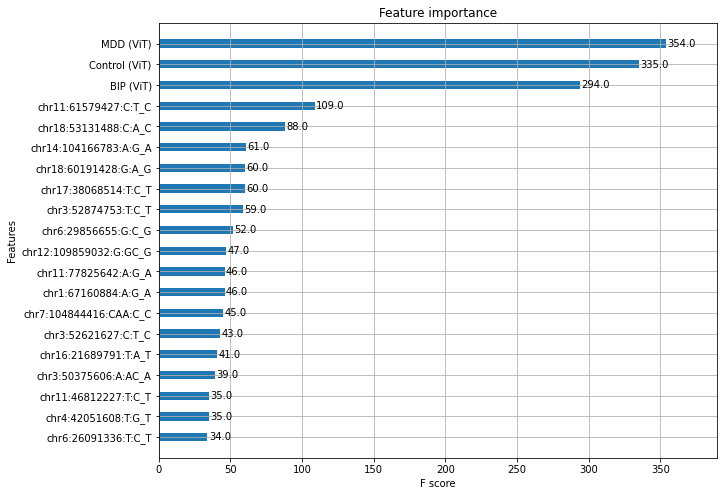

In [83]:
# Plot feature importances as a bar graph

model = joblib.load(filename)
model.feature_names = ['Control (ViT)', 'MDD (ViT)', 'BIP (ViT)'] + list(snp.columns)
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
xgb.plot_importance(model, ax=ax, max_num_features=20, height=0.4)